In [1]:
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

simulator = Aer.get_backend('qasm_simulator')

from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')

from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

# For Error Mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# For Noise Simulations
from qiskit.test.mock import FakeMelbourne
fake_device = FakeMelbourne()

from qiskit.providers.aer.noise import NoiseModel

# Function for Finding Metrics

In [2]:
def metrics(counts):
    phi_plus, psi_plus, phi_minus, psi_minus = 0, 0, 0, 0 

    for result in counts:        
        if (result[-1]=='0' and result[0]=='0'): 
            phi_plus += counts[result]
        elif (result[-1]=='0' and result[0]=='1'): 
            psi_plus += counts[result]
        elif (result[-1]=='1' and result[0]=='0'): 
            phi_minus += counts[result]
        elif (result[-1]=='1' and result[0]=='1'): 
            psi_minus += counts[result]

    total = phi_plus + psi_plus + phi_minus + psi_minus
    print('total:', total)

    print('phi+:', phi_plus, ',', 'psi+:', psi_plus, ',', 'phi-:', phi_minus, ',', 'psi-:', psi_minus)
    fidelity = phi_plus/total
    print('fidelity', fidelity)

# Creating Circuit

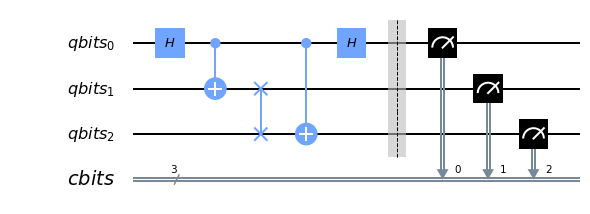

In [14]:
#no. of swap gates, a.k.a., length of channel
n = 1

qbits = QuantumRegister(n+2, 'qbits')
cbits = ClassicalRegister(n+2, 'cbits')

sys = QuantumCircuit(qbits, cbits)

# preparing bell pair
sys.h(qbits[0])
sys.cx(qbits[0], qbits[1])

for i in range (0, n):
    sys.swap(qbits[i+1], qbits[i+2])

# bell-basis measurement
sys.cx(qbits[0], qbits[n+1])
sys.h(qbits[0])

sys.barrier()

sys.measure(qbits, cbits)

sys.draw(output='mpl')

# Running on Real Device

In [ ]:
shots = 8192
job = execute(sys, 
              backend=device, shots=shots, optimization_level=0)

print(job.job_id())
job_monitor(job)

In [ ]:
device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)

In [ ]:
metrics(device_counts)

# Error Mitigation

In [ ]:
#generating calibration circuits
cal_circuits, state_labels = complete_meas_cal(qr=sys.qregs[0],
                                               circlabel='measurement_calibration')

# running calibration circuits
cal_job = execute(cal_circuits, 
                  backend=device, shots=8192, optimization_level=0)

print(cal_job.job_id())
job_monitor(cal_job)

In [ ]:
cal_results = cal_job.result()

# creating mitigation filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

In [ ]:
# error mitigation
mitigated_result = meas_filter.apply(device_result)
mitigated_counts = mitigated_result.get_counts(0)

print(mitigated_counts)

In [ ]:
metrics(mitigated_counts)

# Noisy Simulation

In [15]:
noise_model = NoiseModel.from_backend(fake_device)
coupling_map = fake_device.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [17]:
shots = 8192
noise_job = execute(sys, 
                    backend=simulator, shots=shots, optimization_level=0, 
                    noise_model=noise_model, 
                    #coupling_map=coupling_map,
                    basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)

7b38e63c-95c4-4d7f-9047-a076530297af
Job Status: job has successfully run


In [18]:
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts)

{'010': 483, '101': 622, '000': 4046, '011': 351, '001': 972, '100': 901, '110': 455, '111': 362}
total: 8192
phi+: 4529 , psi+: 1356 , phi-: 1323 , psi-: 984
fidelity 0.5528564453125
